<h1 style="color:red" align="center">TadGAN - Time series anomaly detection using GAN</h1>

### Import needed/required libraries

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from scipy import stats

import pandas as pd
import matplotlib.pyplot as plt

<h1 align="center">Model's Architecture</h1>

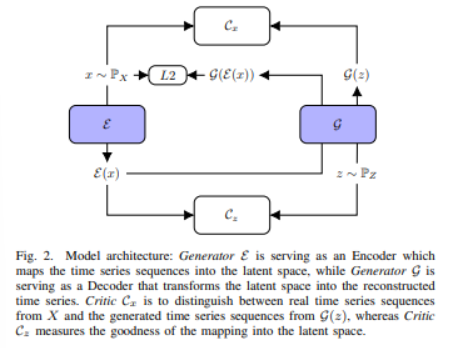


<h1 align="center">TadGan Pseudo-Code</h1>

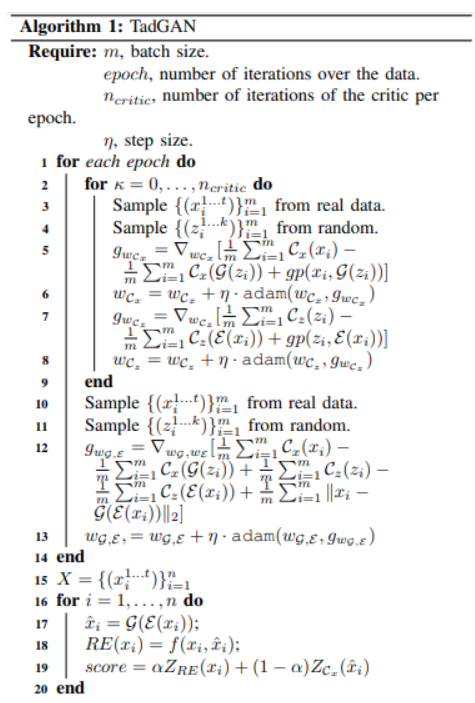<h1 align="center"></h1>

In [24]:
class Encoder(nn.Module):

    def __init__(self, encoder_path, signal_shape=100):
        super(Encoder, self).__init__()
        self.signal_shape = signal_shape

        # lstm = long short-term memory
        self.lstm = nn.LSTM(input_size=self.signal_shape,
                            hidden_size=20, # Latent space dimension
                            num_layers=1,   # Nb of layers
                            bidirectional=True) # Forward & Backward

        self.dense = nn.Linear(in_features=40, out_features=20)
        self.encoder_path = encoder_path

    def forward(self, x):
        x = x.view(1, 64, self.signal_shape).float()
#         print("x.view",x,"\n\n np.shape(x)",np.shape(x))
        x, (hn, cn) = self.lstm(x)
        #print(self.lstm(x, (hn,cn)))
        x = self.dense(x)
        return (x)

<h1 align="center">Define the Model</h1>

### Define the Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, decoder_path, signal_shape=100):
        super(Decoder, self).__init__()
        self.signal_shape = signal_shape
        self.lstm = nn.LSTM(input_size=20,
                            hidden_size=64,
                            num_layers=2,
                            bidirectional=True)
        self.dense = nn.Linear(in_features=128, out_features=self.signal_shape)
        self.decoder_path = decoder_path

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = self.dense(x)
        return (x)

## THE CRITICS

In the following code we introduce 2  two adversarial **critics** (aka discriminators) Cx and Cz.
- **Cx**: distinguish between the real time series sequences from X and the generated time series sequences from G(z)
- **Cz**: measure the performance of the mapping into latent space.

In other words, G is trying to fool Cx by generating real-looking sequences.

Thus, our high-level objective consists of two terms:
    (1) Wasserstein losses, to match the distribution of generated time series sequences to the data distribution in
the target domain
    (2) cycle consistency losses, to prevent the contradiction between E and G (encoder and decoder)
    
### Define the CriticX :

REMINDER: The goal of Cx is to distinguish between the real time series sequences from X and the generated time series sequences from G(z) by using Wasserstein loss

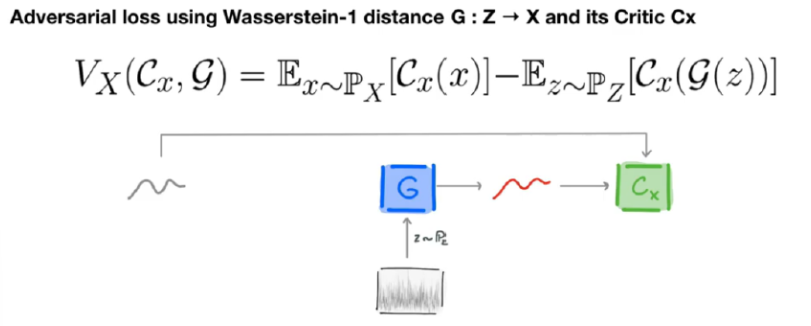

In [26]:

class CriticX(nn.Module):
    def __init__(self, critic_x_path, signal_shape=100):
        super(CriticX, self).__init__()
        self.signal_shape = signal_shape
        self.dense1 = nn.Linear(in_features=self.signal_shape, out_features=20)
        self.dense2 = nn.Linear(in_features=20, out_features=1)
        self.critic_x_path = critic_x_path

    def forward(self, x):
        x = x.view(1, 64, self.signal_shape).float()
        x = self.dense1(x)
        x = self.dense2(x)
        return (x)

### Define the CriticZ

Cz measures the performance of the mapping into latent space.

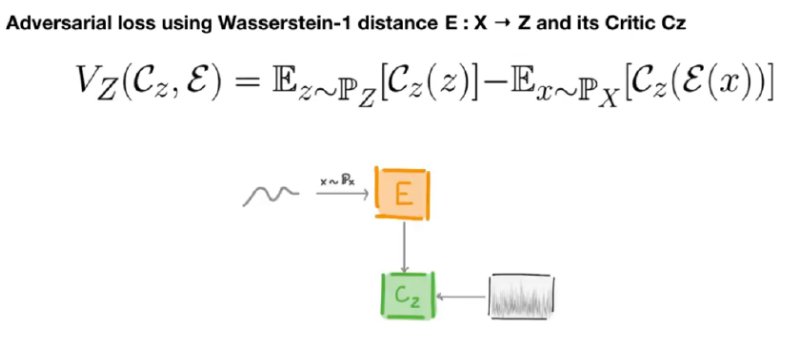

In [27]:
class CriticZ(nn.Module):
    def __init__(self, critic_z_path):
        super(CriticZ, self).__init__()
        self.dense1 = nn.Linear(in_features=20, out_features=1)
        self.critic_z_path = critic_z_path

    def forward(self, x):
        x = self.dense1(x)
        return (x)

    def unroll_signal(self, x):
        x = np.array(x).reshape(100)
        return np.median(x)

    def test(self):

        #Returns a dataframe with original value, reconstructed value, reconstruction error, critic score
        df = self.test_dataset.copy()
        X_ = list()

        RE = list()  #Reconstruction error
        CS = list()  #Critic score

        for i in range(0, df.shape[0]):
            x = df.rolled_signal[i]
            x = tf.reshape(x, (1, 100, 1))
            z = encoder(x) #E(x)
            z = tf.expand_dims(z, axis=2)
            x_ = decoder(z) #G(E(x))

            re = dtw_reconstruction_error(tf.squeeze(x_).numpy(), tf.squeeze(x).numpy()) #reconstruction error
            cs = critic_x(x)
            cs = tf.squeeze(cs).numpy()
            RE.append(re)
            CS.append(cs)

            x_ = unroll_signal(x_)

            X_.append(x_)

        df['generated_signals'] = X_

        return df

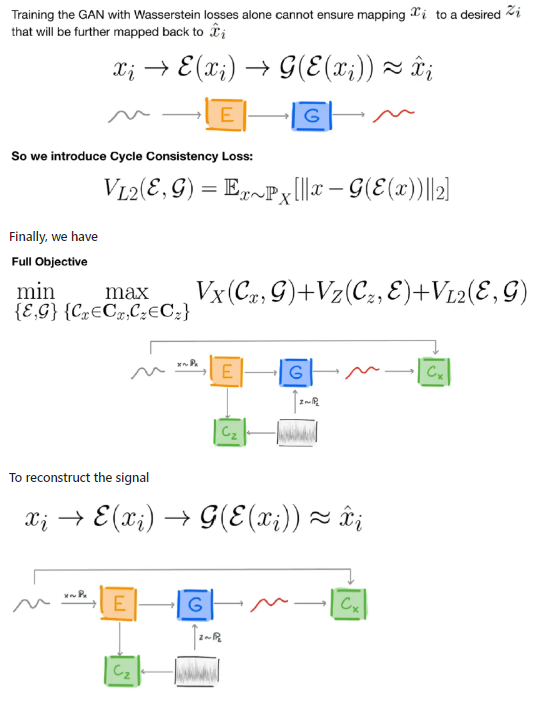

<h1 align="center">Define the Anomaly Detection</h1>

### Other error metrics - point wise difference, Area difference.

In [28]:
def dtw_reconstruction_error(x, x_):
    n, m = x.shape[0], x_.shape[0]
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - x_[j-1])
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[n][m]

### Function to prune the false positive

In [29]:
def prune_false_positive(is_anomaly, anomaly_score, change_threshold):
    #The model might detect a high number of false positives.
    #In such a scenario, pruning of the false positive is suggested.
    #Method used is as described in the Section 5, part D Identifying Anomalous
    #Sequence, sub-part - Mitigating False positives
    seq_details = []
    delete_sequence = 0
    start_position = 0
    end_position = 0
    max_seq_element = anomaly_score[0]
    for i in range(1, len(is_anomaly)):
        if i+1 == len(is_anomaly):
            seq_details.append([start_position, i, max_seq_element, delete_sequence])
        elif is_anomaly[i] == 1 and is_anomaly[i+1] == 0:
            end_position = i
            seq_details.append([start_position, end_position, max_seq_element, delete_sequence])
        elif is_anomaly[i] == 1 and is_anomaly[i-1] == 0:
            start_position = i
            max_seq_element = anomaly_score[i]
        if is_anomaly[i] == 1 and is_anomaly[i-1] == 1 and anomaly_score[i] > max_seq_element:
            max_seq_element = anomaly_score[i]

    max_elements = list()
    for i in range(0, len(seq_details)):
        max_elements.append(seq_details[i][2])

    max_elements.sort(reverse=True)
    max_elements = np.array(max_elements)
    change_percent = abs(max_elements[1:] - max_elements[:-1]) / max_elements[1:]

    #Appending 0 for the 1 st element which is not change percent
    delete_seq = np.append(np.array([0]), change_percent < change_threshold)

    #Mapping max element and seq details
    for i, max_elt in enumerate(max_elements):
        for j in range(0, len(seq_details)):
            if seq_details[j][2] == max_elt:
                seq_details[j][3] = delete_seq[i]

    for seq in seq_details:
        if seq[3] == 1: #Delete sequence
            is_anomaly[seq[0]:seq[1]+1] = [0] * (seq[1] - seq[0] + 1)

    return is_anomaly

### Function to detect anomaly

Here we create the training sample by subdividing the original time series

In [30]:
def detect_anomaly(anomaly_score):
    '''
    define the training sample by introducing a sliding window
    a size t =len(anomaly_score) // 3
    and a stepsize s = len(anomaly_score) // (3 * 10)

    Thus the original time series is divided into N sub-sequences X = {(x{1...t}i)}N{i=1}, where N =(T −t)/s
    '''
    window_size = len(anomaly_score) // 3
    step_size = len(anomaly_score) // (3 * 10)

    is_anomaly = np.zeros(len(anomaly_score))

    for i in range(0, len(anomaly_score) - window_size, step_size):
        window_elts = anomaly_score[i:i+window_size] # sliding window of size window_size
        window_mean = np.mean(window_elts)
        window_std = np.std(window_mean)

        for j, elt in enumerate(window_elts):
            if (window_mean - 3 * window_std) < elt < (window_mean + 3 * window_std):
                is_anomaly[i + j] = 0
            else:
                is_anomaly[i + j] = 1

    return is_anomaly

### Function to find score

<u>Reminder</u>:

$ \boxed{ Accuracy = \frac {T_{P}+T_{N}} {N_{total}} } $.
<b style="color:red">ACCURACY used to know HOW WELL the PREDICTION IS</b>.

$ \boxed{ Precision = \frac {T_{P}} {T_{P}+F_{P}} } $.
<b style="color:red">PRECISION used to know HOW WELL/ACCURATE a POSITIVE IS DETERMINED</b>.

$ \boxed{ Recall/Sensitivity = \frac {T_{P}} {T_{P}+F_{N}} } $.
<b style="color:red">RECALL or SENSITIVITY used to know HOW MUCH POSITIVES ARE DETERMINED</b>.

$ \boxed{ F1  score = \frac {2} {Precision^{-1} + Recall^{-1}} = \frac {2 . Precision . Recall} {Precision + Recall} = \frac {T_{P}} {T_{P} + \frac{1}{2} (F_{N}+F_{P})} } $.


In [31]:
def find_scores(y_true, y_predict):
    EPS = 1e-7 # Avoiding division by 0
    tp = tn = fp = fn = 0

    for i in range(0, len(y_true)):
        if y_true[i] == 1 and y_predict[i] == 1:
            tp += 1
        elif y_true[i] == 1 and y_predict[i] == 0:
            fn += 1
        elif y_true[i] == 0 and y_predict[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_predict[i] == 1:
            fp += 1
    print("tp",tp,"\n\ntn",tn,"\n\nfp",fp,"\n\nfn",fn)
    print ('Accuracy {:.2f}'.format((tp + tn)/(len(y_true)+EPS)))
    precision = tp / (tp + fp + EPS)
    recall = tp / (tp + fn + EPS)
    print ('Precision {:.2f}'.format(precision))
    print ('Recall {:.2f}'.format(recall))
    print ('F1 Score {:.2f}'.format(2 * precision * recall / (precision + recall + EPS)))

<h1 align="center">Apply the model</h1>

### To debug

In [32]:
logging.basicConfig(filename='train.log', level=logging.DEBUG)

### Define the Dataset

In [33]:
class SignalDataset(Dataset):
    def __init__(self, path):
        self.signal_df = pd.read_csv(path)
        self.signal_columns = self.make_signal_list()
        self.make_rolling_signals()

    def make_signal_list(self):
        signal_list = list()
        for i in range(-50, 50):
            signal_list.append('signal'+str(i))
        return signal_list

    def make_rolling_signals(self):
        for i in range(-50, 50):
            self.signal_df['signal'+str(i)] = self.signal_df['signal'].shift(i)
        self.signal_df = self.signal_df.dropna()
        self.signal_df = self.signal_df.reset_index(drop=True)

    def __len__(self):
        return len(self.signal_df)

    def __getitem__(self, idx):
        row = self.signal_df.loc[idx]
        x = row[self.signal_columns].values.astype(float)
        x = torch.from_numpy(x)
        return {'signal':x, 'anomaly':row['anomaly']}

## Define the CriticX training (compute the wassertein loss for critic X)

**GP** stands for **Gradient Penalty**

From a sample a data (*subdivision of the original time series*) we generate $Z={(z_{1},z_{2},...,z_{k})}$ from a random space following normal distribution, where $k$ denotes the dimension of the latent space. Here we **encode $x$ in $z$**.

- STEP 1 : Resizing x
- STEP 2 : Estimate the Anomaly Scores with Critic X Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{x}(x_{i}) \\
\end{equation}

- STEP 3 : Estimate the Anomaly Scores with Critic Z Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{x}(G(z_{i})) \\
\end{equation}

- STEP 4 : Compute the gradient penalty
\begin{equation}
gp(x_{i}, G(z_{i})) \\
\end{equation}

- STEP 5 :

$$step 2 - step 3 + step 4$$

- STEP 6 : Compute the gradient on $w_{G}$ and $w_{E}$
- STEP 7 : Update the weights $w_{C_{x}}$

\begin{equation}
w_{C_{x}} =w_{C_{x}} + stepSize* adam(w_{C_{x}}, STEP5)\\
\end{equation}

In [34]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    # STEP 1
    x = sample['signal'].view(1, batch_size, signal_shape)

    # STEP 2
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x) #Wasserstein Loss

    # STEP 3
    #The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through encoding x)
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  #Wasserstein Loss


    # STEP 4
    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_) #Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    #Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))


    # STEP 5
    #Critic has to maximize Cx(Valid X) - Cx(Fake X).
    #Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss

    # STEP 6
    loss.backward()
    optim_cx.step()

    return loss

## Define the CriticZ training (compute the wassertein loss for critic Z)

From a sample a data (*subdivision of the original time series*) we generate $Z={(z_{1},z_{2},...,z_{k})}$ from a random space following normal distribution, where $k$ denotes the dimension of the latent space. Here we **encode $x$ in $z$**.

- STEP 1 : Resizing x
- STEP 2 :
Estimate the Anomaly Scores with Critic Z Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{z}(z_{i}) \\
\end{equation}

- STEP 3 : Estimate the Anomaly Scores with Critic Z Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{z}(E(x_{i})) \\
\end{equation}

- STEP 4 : Compute the gradient penalty
\begin{equation}
gp(x_{i}, E(z_{i})) \\
\end{equation}

- STEP 5 :

$$step 2 - step 3 + step 4$$

- STEP 6 : Compute the gradient on $w_{G}$ and $w_{E}$
- STEP 7 : Update the weights $w_{C_{z}}$

\begin{equation}
w_{C_{z}} =w_{C_{z}} + stepSize* adam(w_{C_{z}}, step5)\\
\end{equation}

In [35]:
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    # STEP 1
    x = sample['signal'].view(1, batch_size, signal_shape)

    # STEP 2
#     print("x",x,"\n\n np.shape(x)",np.shape(x))
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    # STEP 3
    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z) #Wasserstein Loss

    # STEP 4
    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_) #Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    # STEP 5
    wl = critic_score_fake_z - critic_score_valid_z
    loss = wl + gp_loss

    # STEP 6
    loss.backward()

    # STEP 7
    optim_cz.step()

    return loss

### Define the Encoder training(compute the adapted cycle consistency loss on encoder)

# ADD INFORMATION ON CYCLE CONSISTENCY LOSS AND HOW THE CRITICS OUTPUT ARE USED TO COMPUTE SCORE

From a sample a data (*subdivision of the original time series*) we generate $Z={(z_{1},z_{2},...,z_{k})}$ from a random space following normal distribution, where $k$ denotes the dimension of the latent space. Here we **encode $x$ in $z$**.

- STEP 1 : Resizing x
- STEP 2 : Estimate the Anomaly Scores with Critic X Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{x}(x_{i}) \\
\end{equation}

- STEP 3 :Estimate the Anomaly Scores with Critic X Outputs

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{x}(G(z_{i})) \\
\end{equation}

- STEP 4 :
\begin{equation}
\frac{1}{m} \sum_{i=1}^m ||x_{i} - G(E(x_{i}))||^2 \\
\end{equation}

- STEP 5 :

$$step 2 - step 3 + step 4$$

- STEP 6 : Compute the the gradient on $w_{G}$ and $w_{E}$
- STEP 7 : Update the weights $w_{G,E}$

\begin{equation}
w_{G,E} =w_{G,E} + stepSize* adam(w_{G,E}, STEP5)\\
\end{equation}

In [36]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    # STEP 1 :
    x = sample['signal'].view(1, batch_size, signal_shape)

    # STEP 2
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x) #Wasserstein Loss

    # STEP3
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    #STEP4
    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc

### Define the Decoder training (compute the adapted cycle consistency loss on decoder)

From a sample a data (*subdivision of the original time series*) we generate $Z={(z_{1},z_{2},...,z_{k})}$ from a random space following normal distribution, where $k$ denotes the dimension of the latent space. Here we **encode $x$ in $z$**.

- STEP 1 : Resizing x
- STEP 2 :

\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{z}(z_{i}) \\
\end{equation}

- STEP 3 :
\begin{equation}
\frac{1}{m} \sum_{i=1}^m C_{z}(E(x_{i})) \\
\end{equation}

- STEP 4 :
\begin{equation}
\frac{1}{m} \sum_{i=1}^m ||x_{i} - G(E(x_{i}))||^2 \\
\end{equation}

- STEP 5 :

$$step 2 - step 3 + step 4$$

- STEP 6 : Compute the the gradient on $w_{G}$ and $w_{E}$
- STEP 7 : Update the weights $w_{G,E}$

\begin{equation}
w_{G,E} =w_{G,E} + stepSize* adam(w_{G,E}, STEP5)\\
\end{equation}

In [37]:
def decoder_iteration(sample):
    optim_dec.zero_grad()# VERY IMPORTANT TO PUT IT HERE

    #STEP 1
    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)

    #STEP 2
    #Estimating Anomaly Scores with Critic Z Outputs
    valid_z = critic_z(z) # Cz(z)
    valid_z = torch.squeeze(valid_z) # resize by making it a univariate variable
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z) #compute the score of criticZ

    #STEP 3
    #we use
    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z) #

    #STEP 4
    enc_z = encoder(x)
    gen_x = decoder(enc_z)
    mse = mse_loss(x.float(), gen_x.float())

    #STEP 5
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z

    #STEP 6
    loss_dec.backward(retain_graph=True)

    #STEP 7
    optim_dec.step()

    return loss_dec

### Train the model

In [38]:
def train(n_epochs=2000):
    logging.debug('Starting training')
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    if not os.path.exists("models"):
        os.makedirs("models")

    for epoch in range(n_epochs):
        logging.debug('Epoch {}'.format(epoch))
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, sample in enumerate(train_loader):
                loss = critic_x_iteration(sample) #compute the Wasserstein loss for critic X
                cx_loss.append(loss)

                loss = critic_z_iteration(sample)#compute the Wasserstein loss for critic Z
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss))) # compute the mean of criticx loss on all samples
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss))) #  compute the mean of criticx loss on all samples

        logging.debug('Critic training done in epoch {}'.format(epoch))
        encoder_loss = list()
        decoder_loss = list()

        for batch, sample in enumerate(train_loader):
            enc_loss = encoder_iteration(sample) #compute the adapted cycle consistency loss by minimizing the L2 norm on the encoder
            dec_loss = decoder_iteration(sample) #compute the adapted cycle consistency loss by minimizing the L2 norm on the decoder
            encoder_loss.append(enc_loss) #add the encoder loss in a tab where the indice corresponds to the sample
            decoder_loss.append(dec_loss)


        # preprocess the data for printing
        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))


        logging.debug('Encoder decoder training done in epoch {}'.format(epoch))
        logging.debug('critic x loss {:.3f} critic z loss {:.3f} \nencoder loss {:.3f} decoder loss {:.3f}\n'.format(cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))

        # save data if the encoder, decoder, critic_x and critic_z every 10 epochs
        if epoch % 10 == 0:
            torch.save(encoder.state_dict(), encoder.encoder_path)
            torch.save(decoder.state_dict(), decoder.decoder_path)
            torch.save(critic_x.state_dict(), critic_x.critic_x_path)
            torch.save(critic_z.state_dict(), critic_z.critic_z_path)

### Test the model

In [42]:
def test(test_loader, encoder, decoder, critic_x):
    reconstruction_error = list()
    critic_score = list()
    y_true = list()

    for batch, sample in enumerate(test_loader):
        reconstructed_signal = decoder(encoder(sample['signal']))
        reconstructed_signal = torch.squeeze(reconstructed_signal)

        for i in range(0, 64):
            x_ = reconstructed_signal[i].detach().numpy()
            x = sample['signal'][i].numpy()
            y_true.append(int(sample['anomaly'][i].detach()))
            reconstruction_error.append(dtw_reconstruction_error(x, x_))
        critic_score.extend(torch.squeeze(critic_x(sample['signal'])).detach().numpy())

    reconstruction_error = stats.zscore(reconstruction_error)
    critic_score = stats.zscore(critic_score)
    anomaly_score = reconstruction_error * critic_score
    y_predict = detect_anomaly(anomaly_score)
    y_predict = prune_false_positive(y_predict, anomaly_score, change_threshold=0.1)
    find_scores(y_true, y_predict)

<h1 align="center">Launch the training</h1>

In [47]:
dataset = pd.read_csv("/content/drive/MyDrive/exchange-2_cpc_results.csv")
#Splitting intro train and test
train_len = int(0.7 * dataset.shape[0])
dataset[0:train_len].to_csv('train_dataset.csv', index=False)
dataset[train_len:].to_csv('test_dataset.csv', index=False)

train_dataset = SignalDataset(path='train_dataset.csv')
test_dataset = SignalDataset(path='test_dataset.csv')
batch_size = 64 #define the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

logging.info('Number of train datapoints is {}'.format(len(train_dataset)))
logging.info('Number of samples in train dataset {}'.format(len(train_dataset)))

lr = 1e-6

signal_shape = 100
latent_space_dim = 20
encoder_path = 'models/encoder.pt'
decoder_path = 'models/decoder.pt'
critic_x_path = 'models/critic_x.pt'
critic_z_path = 'models/critic_z.pt'

encoder = Encoder(encoder_path, signal_shape)
decoder = Decoder(decoder_path, signal_shape)
critic_x = CriticX(critic_x_path, signal_shape)
critic_z = CriticZ(critic_z_path)

mse_loss = torch.nn.MSELoss()

optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))

#launch the training
train(n_epochs=10)

#Launch the testing
test(test_loader, encoder, decoder, critic_x)

<ipython-input-33-e93b56b36860>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
self.signal_df['signal'+str(i)] = self.signal_df['signal'].shift(i)
True Positives (TP): 95
True Negatives (TN): 400
False Positives (FP): 0
False Negatives (FN): 5

Accuracy: 0.99
Precision: 1.0
Recall (Sensitivity): 0.95
F1 Score: 0.975
